# Cityscapes Data Exploration

`gtFine_trainvaltest.zip` and `leftImg8bit_trainvaltest.zip` were downloaded from www.cityscapes-dataset.net and saved to `./data`.

As the filenames would suggest, the data has already been split into train, validation, and test sets. According to the [Cityscapes Dataset paper](https://arxiv.org/pdf/1604.01685.pdf): 
> Specifically, each of the three split sets is comprised of data recorded with the following properties in equal shares: (i) in large, medium,and small cities; (ii) in the geographic west, center, and east; (iii) in the geographic north, center, and south; (iv) at the beginning, middle, and end of the year.  Note that the data is split at the city level,i.e. a city is completely within a single split. Following this scheme, we arrive at a unique split consisting of 2975 training and 500 validation images with publicly available annotations, as well as 1525 test images with annotations withheld for benchmarking purposes.

This notebook performs basic exploratory data analysis on the training images.

In [1]:
# Data manipulation
import os
import glob
import numpy as np
from PIL import Image

# Cityscapes helpers
from cityscapesscripts.helpers import labels

# Torch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Visualization
import matplotlib.pyplot as plt

%matplotlib inline

## General dataset overview

Random image from the training data:

In [2]:
example_img_file = (
    "../data/leftImg8bit/train/stuttgart/stuttgart_000166_000019_leftImg8bit.png"
)
example_img = np.array(Image.open(example_img_file), dtype=np.uint8)
print(example_img.shape)

(1024, 2048, 3)


PIL and numpy format the image as (H x W x C) in the range \[0, 255\]. Torchvision.transforms.ToTensor will automatically transform this into the shape (C x H x W) in the range \[0, 1\]. 

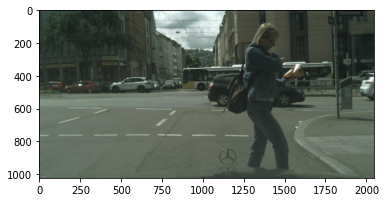

In [3]:
plt.imshow(example_img)

Plot of its corresponding segmentation mask with shape (H x W):

(1024, 2048)


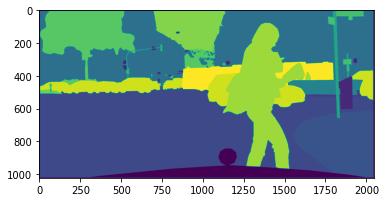

In [4]:
example_mask_file = (
    "../data/gtFine/train/stuttgart/stuttgart_000166_000019_gtFine_labelIds.png"
)
example_mask = np.array(Image.open(example_mask_file), dtype=np.uint8)
print(example_mask.shape)
plt.imshow(example_mask)

In [5]:
example_ids = np.unique(example_mask)
example_labels = [labels.id2label[example_id].name for example_id in example_ids]
for example_id, label in zip(example_ids, example_labels):
    print(example_id, label)

1 ego vehicle
3 out of roi
4 static
6 ground
7 road
8 sidewalk
11 building
13 fence
17 pole
19 traffic light
20 traffic sign
21 vegetation
22 terrain
23 sky
24 person
26 car
28 bus


Cityscapes ignores certain labels for evaluation, so we can create ground truth images with custom train IDs. The following lists all the label information provided by cityscapesscripts:

In [6]:
print("List of cityscapes labels:")
print(
    "    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12}".format(
        "name",
        "id",
        "trainId",
        "category",
        "categoryId",
        "hasInstances",
        "ignoreInEval",
    )
)
print("    " + ("-" * 98))
for label in labels.labels:
    print(
        "    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12}".format(
            label.name,
            label.id,
            label.trainId,
            label.category,
            label.categoryId,
            label.hasInstances,
            label.ignoreInEval,
        )
    )

List of cityscapes labels:
                     name |  id | trainId |       category | categoryId | hasInstances | ignoreInEval
    --------------------------------------------------------------------------------------------------
                unlabeled |   0 |     255 |           void |          0 |            0 |            1
              ego vehicle |   1 |     255 |           void |          0 |            0 |            1
     rectification border |   2 |     255 |           void |          0 |            0 |            1
               out of roi |   3 |     255 |           void |          0 |            0 |            1
                   static |   4 |     255 |           void |          0 |            0 |            1
                  dynamic |   5 |     255 |           void |          0 |            0 |            1
                   ground |   6 |     255 |           void |          0 |            0 |            1
                     road |   7 |       0 |           

As we see here, there are 19 classes that we actually care to classify as the labels that are ignored in evaluation are labeled as 255 or -1. The 'license plate' is labeled as -1, so we'll cast that to 255 as well.

Creating a segmentation mask with custom train IDs:

In [7]:
id_to_trainId = {
    label.id: (label.trainId if label.trainId not in (-1, 255) else 19)
    for label in labels.labels
}
trainId_to_id = {
    trainId: (label_id if trainId != 19 else 0)
    for label_id, trainId in id_to_trainId.items()
}

id_to_trainId

{0: 19,
 1: 19,
 2: 19,
 3: 19,
 4: 19,
 5: 19,
 6: 19,
 7: 0,
 8: 1,
 9: 19,
 10: 19,
 11: 2,
 12: 3,
 13: 4,
 14: 19,
 15: 19,
 16: 19,
 17: 5,
 18: 19,
 19: 6,
 20: 7,
 21: 8,
 22: 9,
 23: 10,
 24: 11,
 25: 12,
 26: 13,
 27: 14,
 28: 15,
 29: 19,
 30: 19,
 31: 16,
 32: 17,
 33: 18,
 -1: 19}

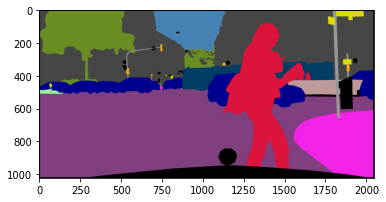

In [8]:
def replace_with_dict(ar, dic):
    """
    https://stackoverflow.com/questions/47171356
    """
    # Extract out keys and values
    k = np.array(list(dic.keys()))
    v = np.array(list(dic.values()))

    # Get argsort indices
    sidx = k.argsort()

    ks = k[sidx]
    vs = v[sidx]
    return vs[np.searchsorted(ks, ar)]


def get_palette():
    """
    Palette sequence used for the Cityscapes annotations.

    From PIL documentation:
    Palette sequence must contain 768 integer values, where each group
    of three values represent the red, green, and blue values for the
    corresponding pixel index.
    """
    palette = []
    trainId_to_color = {label.trainId: label.color for label in labels.labels}
    for i in range(19):
        palette.extend(trainId_to_color[i])
    zero_pads = [0] * (768 - len(palette))
    palette.extend(zero_pads)
    return palette


def color_mask(mask, palette):
    mask = Image.fromarray(mask.astype(np.uint8))
    mask.putpalette(palette)
    return mask


palette = get_palette()
train_mask = replace_with_dict(example_mask, id_to_trainId)
train_mask = color_mask(train_mask, palette)
plt.imshow(train_mask)

In [9]:
unique_trainIds, counts_trainIds = np.unique(train_mask, return_counts=True)
unique_ids, counts_ids = np.unique(example_mask, return_counts=True)
print("train mask:")
print(dict(zip(unique_trainIds, counts_trainIds)))
print("\ntranslated back to id:")
print(
    dict(zip([trainId_to_id[trainId] for trainId in unique_trainIds], counts_trainIds))
)
print("\nexample mask:")
print(dict(zip(unique_ids, counts_ids)))

train mask:
{0: 690662, 1: 149985, 2: 471381, 4: 25236, 5: 15324, 6: 1790, 7: 10857, 8: 149028, 9: 2581, 10: 80225, 11: 199535, 13: 109049, 15: 56553, 19: 134946}

translated back to id:
{7: 690662, 8: 149985, 11: 471381, 13: 25236, 17: 15324, 19: 1790, 20: 10857, 21: 149028, 22: 2581, 23: 80225, 24: 199535, 26: 109049, 28: 56553, 0: 134946}

example mask:
{1: 81534, 3: 31634, 4: 18099, 6: 3679, 7: 690662, 8: 149985, 11: 471381, 13: 25236, 17: 15324, 19: 1790, 20: 10857, 21: 149028, 22: 2581, 23: 80225, 24: 199535, 26: 109049, 28: 56553}


## Create Dataset and DataLoader

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Compile training images and annotations:

In [10]:
IMG_DIR = "../data/leftImg8bit"
MASK_DIR = "../data/gtFine"


def get_img_mask_paths(split, img_root=IMG_DIR, mask_root=MASK_DIR):
    assert split in ("train", "val")
    img_paths = sorted(
        glob.glob(os.path.join(img_root, split, "*", "*_leftImg8bit.png"))
    )
    mask_paths = sorted(
        glob.glob(os.path.join(mask_root, split, "*", "*_labelIds.png"))
    )
    return img_paths, mask_paths


TRAIN_IMG_PATHS, TRAIN_MASK_PATHS = get_img_mask_paths("train")
print(len(TRAIN_IMG_PATHS), len(TRAIN_MASK_PATHS))

2975 2975


In [11]:
sorted(TRAIN_IMG_PATHS)[-6:]

['../data/leftImg8bit/train/zurich/zurich_000116_000019_leftImg8bit.png',
 '../data/leftImg8bit/train/zurich/zurich_000117_000019_leftImg8bit.png',
 '../data/leftImg8bit/train/zurich/zurich_000118_000019_leftImg8bit.png',
 '../data/leftImg8bit/train/zurich/zurich_000119_000019_leftImg8bit.png',
 '../data/leftImg8bit/train/zurich/zurich_000120_000019_leftImg8bit.png',
 '../data/leftImg8bit/train/zurich/zurich_000121_000019_leftImg8bit.png']

In [12]:
sorted(TRAIN_MASK_PATHS)[-6:]

['../data/gtFine/train/zurich/zurich_000116_000019_gtFine_labelIds.png',
 '../data/gtFine/train/zurich/zurich_000117_000019_gtFine_labelIds.png',
 '../data/gtFine/train/zurich/zurich_000118_000019_gtFine_labelIds.png',
 '../data/gtFine/train/zurich/zurich_000119_000019_gtFine_labelIds.png',
 '../data/gtFine/train/zurich/zurich_000120_000019_gtFine_labelIds.png',
 '../data/gtFine/train/zurich/zurich_000121_000019_gtFine_labelIds.png']

In [13]:
class MaskToTensor:
    def __call__(self, mask):
        return torch.as_tensor(np.array(mask), dtype=torch.int64)


class CityscapesDataset(Dataset):
    def __init__(self, split, transform=None, mask_transform=None):
        self.img_paths, self.mask_paths = get_img_mask_paths(split)
        assert len(self.img_paths) == len(self.mask_paths) and len(self.img_paths) > 0

        self.transform = transform
        self.mask_transform = mask_transform

        self.ignoreId = 19
        self.id_to_trainId = {
            label.id: (label.trainId if label.trainId not in (-1, 255) else 19)
            for label in labels.labels
        }
        self.trainId_to_id = {
            trainId: (label_id if trainId != 19 else 0)
            for label_id, trainId in self.id_to_trainId.items()
        }

    def convert_to_trainId(self, mask):
        """
        https://stackoverflow.com/questions/47171356
        """
        k = torch.tensor(list(self.id_to_trainId.keys()))
        v = torch.tensor(list(self.id_to_trainId.values()))
        sidx = k.argsort()

        ks = k[sidx]
        vs = v[sidx]
        return vs[torch.searchsorted(ks, mask)].double()

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = Image.open(self.img_paths[idx])
        mask = Image.open(self.mask_paths[idx])

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        mask = self.convert_to_trainId(mask)
        return {"image": image, "mask": mask}


train_dataset = CityscapesDataset(
    split="train",
    transform=transforms.Compose(
        [
            transforms.Resize((256, 512), interpolation=Image.BILINEAR),
            transforms.ToTensor(),
        ]
    ),
    mask_transform=transforms.Compose(
        [transforms.Resize((256, 512), interpolation=Image.NEAREST), MaskToTensor()]
    ),
)

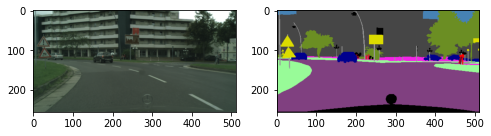

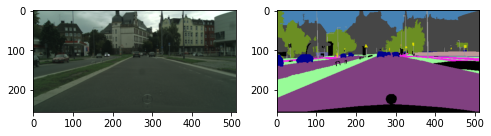

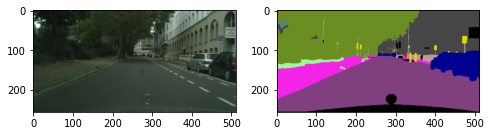

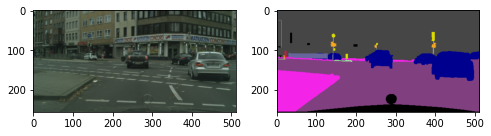

In [14]:
toPIL = transforms.ToPILImage()
for i in range(4):
    sample = train_dataset[i]
    image = toPIL(sample["image"])
    mask = color_mask(sample["mask"].numpy(), palette)
    fig, ax = plt.subplots(1, 2, figsize=(8, 8))
    ax[0].imshow(image)
    ax[1].imshow(mask)
    plt.plot()

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

batch: 0, batchsize: 4


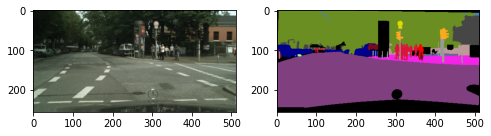

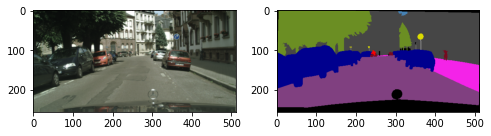

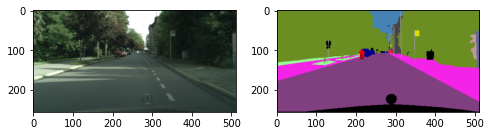

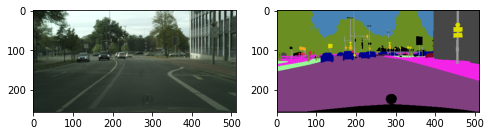

batch: 1, batchsize: 4


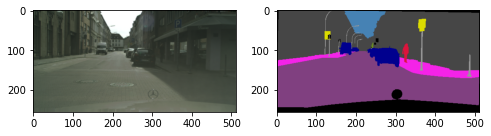

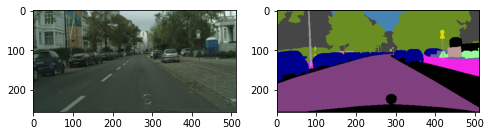

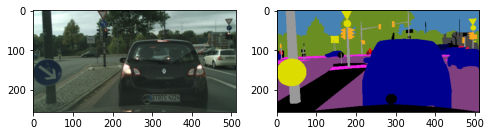

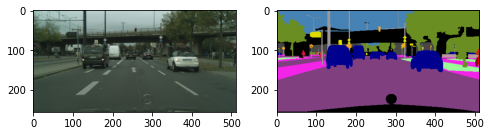

In [16]:
toPIL = transforms.ToPILImage()

for i_batch, sample_batched in enumerate(train_dataloader):
    if i_batch == 2:
        break

    images_batch, masks_batch = sample_batched["image"], sample_batched["mask"]
    print(f"batch: {i_batch}, batchsize: {len(images_batch)}")
    for i in range(len(images_batch)):
        image = toPIL(images_batch[i])
        mask = color_mask(masks_batch[i].numpy(), palette)
        fig, ax = plt.subplots(1, 2, figsize=(8, 8))
        ax[0].imshow(image)
        ax[1].imshow(mask)
        plt.show()

In [17]:
masks_batch[0]

tensor([[19., 19., 19.,  ..., 19., 19., 19.],
        [19., 19., 19.,  ..., 19., 19., 19.],
        [19., 19., 19.,  ..., 19., 19., 19.],
        ...,
        [19., 19., 19.,  ..., 19., 19., 19.],
        [19., 19., 19.,  ..., 19., 19., 19.],
        [19., 19., 19.,  ..., 19., 19., 19.]], dtype=torch.float64)